# Lab 5 - BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Convolução e CNN

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Aplicação de filtros em imagens por meio de convolução
- Entendimento do uso de stride, padding e pooling
- Modelagem de uma rede de convolução para o problema de rec. de face da AT&T
- Uso do VGG pr-e-treinado como um extrator de caracterĩsticas
- Uso do MobileNet pré-treinado para classificação de faces : transferência de aprenzagem
- Notebook baseado em tensorflow e Keras.

Data da entrega : 18/02

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/yAFYEV4YZyT1dYHFA)


# Importando pacotes e montando o drive

In [49]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from tensorflow.keras import datasets, layers, models
import skimage
from skimage import io
from skimage.io import imread
from skimage.transform import resize

%matplotlib inline
import matplotlib.pyplot as plt

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Avaliando a operação de pooling (20pt)

Carregue um imagem do disco, para usar como exemplo.

sample image shape:  (512, 512, 3)


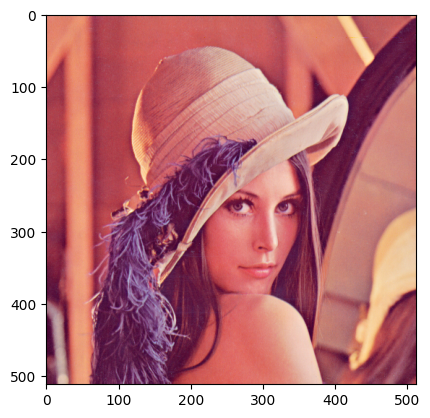

In [51]:
# carrega imagem de exemplo
sample_image = imread("/content/drive/My Drive/Lenna.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

In [52]:
# veja o shape da imagem
sample_image.shape

(512, 512, 3)

Agora que a imagem já está carregada, aplique um max-pooling na imagem, com uma janela de 2x2. Faça com stride de 2 e observe o resultado na imagem de saída.

In [53]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)

max_pool = Sequential([
    keras.layers.MaxPool2D(pool_size=(2, 2), padding="same", input_shape=(None, None, 3))
])
max_pool.output_shape



/usr/local/lib/python3.11/dist-packages/keras/src/layers/pooling/base_pooling.py:23: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


(None, None, None, 3)

In [54]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool.predict(img_in) # aplica o pooling

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


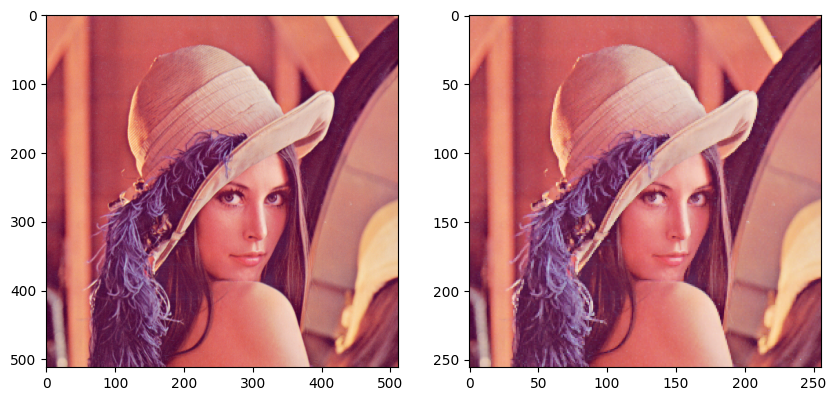

In [55]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 4, repita o processo e observe o resultado na imagem de saída.




In [56]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool2 = Sequential([
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=4, padding="same", input_shape=(None, None, 3))
])
max_pool2.output_shape

(None, None, None, 3)

In [57]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool2.predict(img_in) # aplica o pooling

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


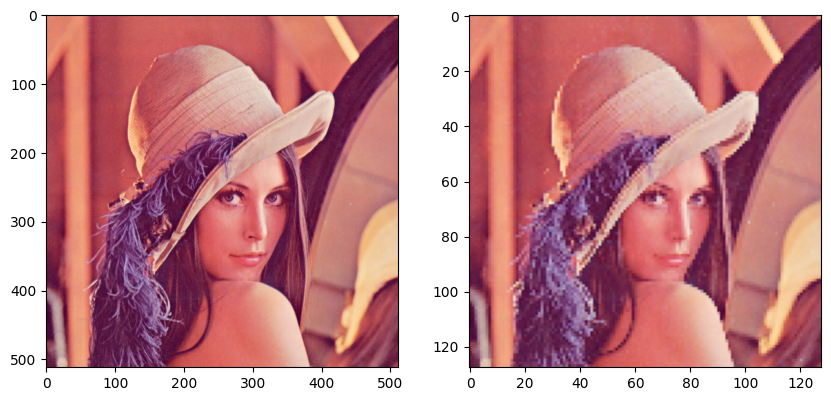

In [58]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 8, repita o processo e observe o resultado na imagem de saída. A

In [59]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool3 = Sequential([
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=8, padding="same", input_shape=(None, None, 3))
])
max_pool3.output_shape

(None, None, None, 3)

In [60]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool3.predict(img_in) # aplica o pooling

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


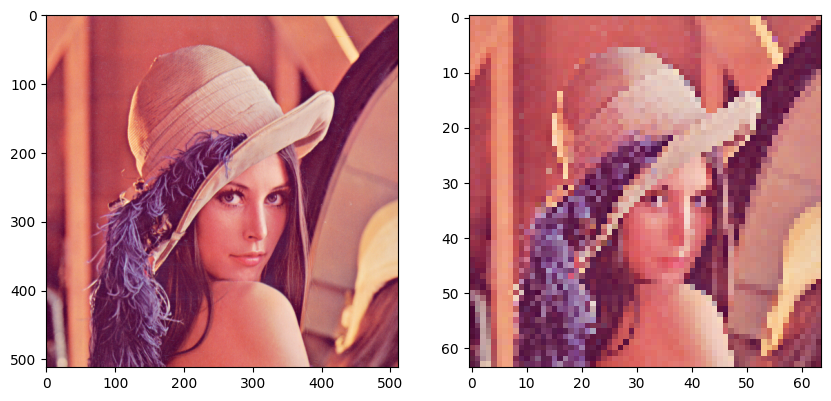

In [61]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

**ToDo:** O que você observou com o aumento do *stride*?

```
 Foto ficou mais pixelada
```

# Reconhecimento de Faces usando uma rede de convolução (20pt)




O objetivo desta etapa é classificar faces na base ORL (AT&T) Database (40 individuos x 10 imagens, de resolução 92x112 pixels e 256 níveis de cinza).

Baixe as imagens no site http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html ou da pasta dataset do Drive.

## Preparando os dados (5pt)

In [62]:
# carregue as imagens

# inicializa matrizes X e y
X = np.empty([400, 112, 92]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/MyDrive/att_faces"
i=0
class_id = 0
for f in os.listdir(imgs_path):
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                X[i, :, :] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id
                i = i + 1


print("dimensões da matriz X = " , X.shape)

dimensões da matriz X =  (400, 112, 92)


In [63]:
# Divida os dados em treino e teste (70%-30%) com a função train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
X_train.shape

(280, 112, 92)

In [65]:
X_test.shape

(120, 112, 92)

## Implementando a rede (15pt)

Implemente uma rede de convolução simples, contendo 3 camadas de convolução seguidas de camadas max-pooling. Duas camadas densas (totalemtne conectadas) no final e por fim uma camada com ativação softmax para a classificação. Escolha filtros de tamanhos variados: (3,3) ou (5,5). Para cada camada, crie de 32 a 96 filtros.
Na camada densa, use de 64 a 200 neurônios.

Use o comando `model.summary()` para conferir a arquitetura.

In [66]:
# Implementa uma rede de convolução simples, chamada model

input_size = (X.shape[1], X.shape[2],1)
n_classes = 40

model = models.Sequential()

model.add(layers.InputLayer(input_size))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same", input_shape=(None, None, 3)))

# ToDo : adicionar as outras camadas

model.add(layers.Flatten()) # não esqueça da camada flatten ..

model.add(layers.Dense(64,activation = 'relu' ))
model.add(layers.Dense(40,activation = 'sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/pooling/base_pooling.py:23: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 110, 90, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 55, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 79200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       5,068,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 40)                  │           2,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,071,784 (19.35 MB)

 Trainable params: 5,071,784 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

Seu modelo deve ter uma saída aproximadamente como abaixo:



```
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_60 (Conv2D)           (None, 110, 90, 32)       320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 45, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 53, 43, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 21, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 19, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 29184)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1867840   
_________________________________________________________________
dense_10 (Dense)             (None, 40)                2600      
=================================================================
Total params: 1,926,184
Trainable params: 1,926,184
Non-trainable params: 0
_________________________________________________________________
```



Repare bem o shape de `x_train`. A primeira dimensão é o tamanho do lote, a segunda e terceira são referentes ao tamanho das imagens. Repare também que as imagens desta base tem apenas uma banda (escala de cinza).

In [67]:
X_train.shape

(280, 112, 92)

Como o tensor acima não contempla o tamanho de canais (no caso , igual a 1), deve-se expandir a última dimensão para deixar a entrada compatível com o que é esperado pelo modelo do `tf.keras`.

In [68]:
X_train_new = np.expand_dims(X_train, axis=-1)
X_test_new = np.expand_dims(X_test, axis=-1)

X_train_new.shape

(280, 112, 92, 1)

Já que corrigimos o *shape* das imagens, é necessário corrigir para os labels, isso porque o vetor de rótulos não precisa ter duas dimensões.

In [69]:
y_train_new = y_train.squeeze()
y_test_new = y_test.squeeze()

# e deve ficar na faixa entre 0 e 39
y_train_new = y_train_new;
y_test_new = y_test_new;

Compile o modelo usando o método de otimização=adam e função de custo `(loss) = sparse_categorical_crossentropy`.

In [70]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Treine o modelo por 30 épocas com `batch_size = 100`.

In [71]:
history = model.fit(X_train_new, y_train_new, epochs=30, batch_size=100, validation_split=0.2)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - accuracy: 0.4993 - loss: 101.4654 - val_accuracy: 0.8036 - val_loss: 247.0965
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7574 - loss: 213.1808 - val_accuracy: 0.8036 - val_loss: 157.6213
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7574 - loss: 151.8434 - val_accuracy: 0.8036 - val_loss: 159.5555
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7712 - loss: 114.2317 - val_accuracy: 0.8036 - val_loss: 112.4823
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7624 - loss: 54.4150 - val_accuracy: 0.8036 - val_loss: 71.8956
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7824 - loss: 39.2431 - val_accuracy: 0.8036 - val_loss: 51.5164
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7737 - loss: 28.2897 - val_accuracy: 0.8036 - val_loss: 33.8759
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7612 - loss: 13.8882 - val_accuracy: 0.

O retorno da função `fit()` é um objeto para armazenar o histõrico do treino.

In [72]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Plote a acurácia e o custo (*loss*) do treino e da validação.

4/4 - 1s - 128ms/step - accuracy: 0.6917 - loss: 2.3505


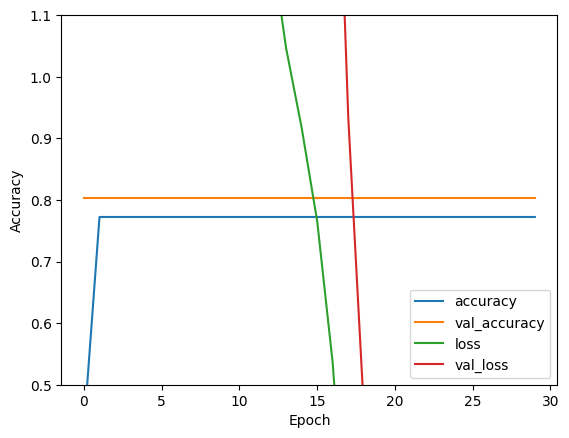

In [73]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_new,  y_test_new, verbose=2)

In [74]:
print(test_acc)

0.6916666626930237


# Usando um modelo Pré-treinado : VGG (10pt)

Carregando os dados da base AT&T para o VGG. Como a base está em escala de cinza e a entrada do modelo VGG espera uma imagem colorida (RGB), vamos repetir a mesma imagem em cada uma das bandas.

## Preparando os dados (2pt)


In [75]:
# inicializa matrizes X e y
X = np.empty([400, 112, 92, 3]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/MyDrive/att_faces"
i=0
class_id = 0
for f in os.listdir(imgs_path):
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                # copia msg imagem para os 3 canais
                X[i, :, :,0] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,1] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,2] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id-1
                i = i + 1



Dividindo os dados em 70% treino e 30% teste.

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(280, 112, 92, 3)

## Carrando o VGG direto da biblioteca do tensorflow (2pt)

In [77]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br

from tensorflow.keras.applications import VGG19
vgg19 = VGG19()

Vamos avaliar o modelo carregado.

In [78]:
vgg19.summary() # repare a quantidade de parãmetros!

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

Vamos descartar as duas últimas camadas do VGG

In [79]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br
from tensorflow.keras.models import Model

vgg_face_descriptor = Model(inputs=vgg19.input, outputs=vgg19.layers[-2].output)

**ToDo** - Por que descartamos as duas últimas camadas do VGG?



```
 Descartamos as duas últimas camadas do VGG porque elas são específicas para a classificação original do modelo. Ao removê-las, usamos o VGG apenas como extrator de características, permitindo a adaptação para um novo problema com novas camadas personalizadas.
```

# Transferência de aprendizado (50pt)


Estude o tutorial do [link](https://www.tensorflow.org/tutorials/images/transfer_learning) e aplique o mesmo procedimento para ajustar um modelo previamente treinado com imagens da imagenet.
Use o MobileNetV2 como modelo base.

Faça o procedimento em duas etapas:


1.   Congele todas as camadas exceto as novas que você adicinou ao modelo. Treine.
2.   Libere todas as camadas paar o treinamento e treine novamente com um Learning Rate bem pequeno (um décimo do realizado no ítem 1).

In [80]:
# Usando o mobileNet, as imagens devem ter entrada de 160x160x3 e normalizadas entre 0 e 1.
# Use a funçao abaixo para fazer o trabalho, conjuntamente com tf.data.Dataset.from_tensor_slices

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [81]:
X_train.shape

(280, 112, 92, 3)

O Tensorflow tem funções específicas para carregar os dados. Veja `tf.data.Dataset`.

In [82]:
raw_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
raw_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [83]:
train = raw_train.map(format_example)
test = raw_test.map(format_example)

Seus dados devem ter o formato :



```
TensorShape([Dimension(280), Dimension(160), Dimension(160), Dimension(3)])

```



In [84]:
SHUFFLE_BUFFER_SIZE = 400
BATCH_SIZE = 32
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Com os dados preparados, execute os seguintes passos:
1. Carregue o modelo pré-treinado do MobileNet, remova a última camada.
2. Adicione uma camdada de Global Average Pooling 2D (GAP)
3. Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax
4. Use função de custo loss='sparse_categorical_crossentropy'
5. Dentre os dados de treinamento, reserve 10% para validação do modelo.
6. Treine por 10 épocas.
7. Plote os gráficos de custo do treino e validação


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_160 (Functional)      │ (None, 5, 5, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 40)                  │          41,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,269,864 (12.47 MB)

 Trainable params: 41,000 (160.16 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 647ms/step - accuracy: 0.0186 - loss: 4.9975 - val_accuracy: 0.0714 - val_loss: 3.6202
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1297 - loss: 3.1165 - val_accuracy: 0.9286 - val_loss: 2.1605
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8763 - loss: 1.8067 - val_accuracy: 0.9643 - val_loss: 0.9728
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9541 - loss: 0.7993 - val_accuracy: 1.0000 - val_loss: 0.3677
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.3362 - val_accuracy: 1.0000 - val_loss: 0.1682
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.1669 - val_accuracy: 1.0000 - val_loss: 0.1049
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1069 - val_accuracy: 1.0000 - val_loss: 0.0777
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0858 - val_accuracy: 1.0000 - val_loss: 0.064

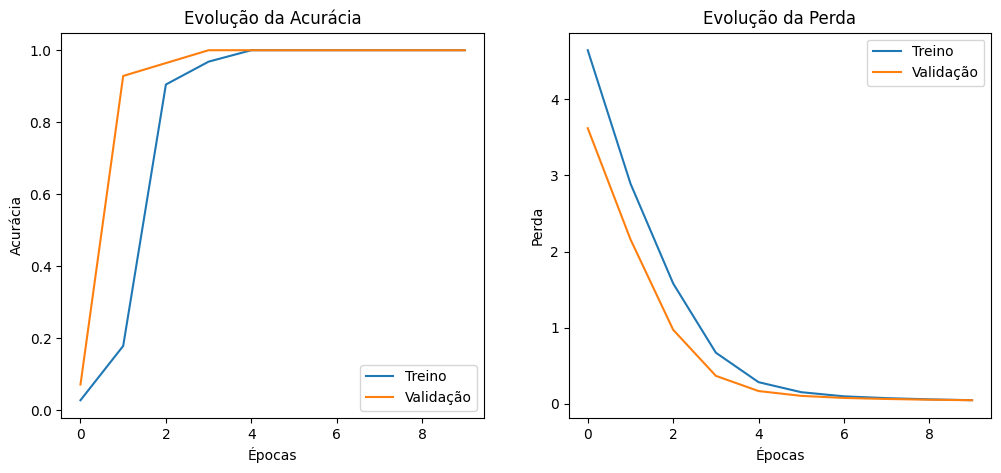

In [85]:
# Carregar MobileNet sem a camada de saída original
base_mobilenet = tf.keras.applications.MobileNet(include_top=False, input_shape=(160, 160, 3))
base_mobilenet.trainable = False  # Congela os pesos do modelo base

# Construção do novo modelo
model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),  # Redução para vetor de características
    layers.Dense(40, activation='softmax')  # Saída com 40 classes
])

# Compilação do modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Exibir resumo do modelo
model.summary()

# Separação dos dados em treino e validação
total_amostras = tf.data.experimental.cardinality(raw_train).numpy()
valid_size = int(0.1 * total_amostras)  # 10% para validação

val_data = train.take(valid_size).batch(BATCH_SIZE)
train_data = train.skip(valid_size).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Treinamento do modelo
historico = model.fit(train_data, validation_data=val_data, epochs=10)

# Gráficos de acurácia e perda
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico.history['accuracy'], label='Treino')
plt.plot(historico.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')

plt.subplot(1, 2, 2)
plt.plot(historico.history['loss'], label='Treino')
plt.plot(historico.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Evolução da Perda')

plt.show()